# Buscalibre Review Data Analysis (For Topic Classification)

2nd Part of the analysis of the buscalibre data. **This time, the analysis is done on the review column**.


## Data Import

Import the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from scipy.stats import skew
sns.set_style("darkgrid")
sns.set_palette("Set2", 10)
palette = sns.color_palette("Set2", 10)
plt.style.use("seaborn")
import spacy
sp = spacy.load("es_core_news_sm")
stopwords = sp.Defaults.stop_words
import gc
import re

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Load the data.

In [2]:
path_folder = os.getcwd().replace("\\", "/") + "/"
path_parent = os.path.dirname(os.getcwd()).replace("\\", "/") + "/"
train = pd.read_csv(path_folder + "train_1.csv")
test = pd.read_csv(path_folder + "test_1.csv")

Define a dataframe for both Training and Test sets, being the last 700 rows for the Test set.

In [3]:
df = pd.concat([train, test], ignore_index=True)
print(df.shape)

(3364, 21)


In [4]:
df.head()

,isbn,review,topic,year_scaled,root_pages,root_price,author_male,author_female,espiritualidad-y-auto-ayuda_Pub_Encode,1-5-anos_Pub_Encode,...,juvenil_Pub_Encode,romántica-y-erotica_Pub_Encode,best-sellers-no-ficcion_Pub_Encode,best-sellers-ficcion_Pub_Encode,finanzas-y-economia_Pub_Encode,biografias_Pub_Encode,cocina-y-alimentacion_Pub_Encode,actualidad-y-politica_Pub_Encode,ocio-y-humor_Pub_Encode,grandes-descuentos_Pub_Encode
0,9789563606843,¿Te ha pasado que los días previos a un evento...,espiritualidad-y-auto-ayuda,0.966102,6.409340,20.344048,0,1,0.113,0.0304,...,0.0522,0.0261,0.1087,0.2174,0.0043,0.0261,0.0304,0.0478,0.0783,0.1826
1,9789563608595,¿Por qué el crecimiento personal es clave a la...,espiritualidad-y-auto-ayuda,1.000000,9.387404,22.779236,1,0,0.113,0.0304,...,0.0522,0.0261,0.1087,0.2174,0.0043,0.0261,0.0304,0.0478,0.0783,0.1826
2,9789563609271,"El año 2019, la periodista Javiera Suárez dejó...",espiritualidad-y-auto-ayuda,1.000000,7.218571,22.219564,1,0,0.113,0.0304,...,0.0522,0.0261,0.1087,0.2174,0.0043,0.0261,0.0304,0.0478,0.0783,0.1826
3,9789501519914,"En este fascinante y persuasivo libro, Daniel ...",espiritualidad-y-auto-ayuda,0.711864,10.952574,22.273447,1,0,0.050,0.0000,...,0.3000,0.1500,0.0000,0.1500,0.0000,0.1000,0.0000,0.0000,0.0500,0.1500
4,9789502805924,El poder del ahora es un libro único. Tiene la...,espiritualidad-y-auto-ayuda,0.644068,9.189587,23.869664,0,1,0.250,0.0000,...,0.0000,0.1389,0.1389,0.1389,0.0000,0.0000,0.2500,0.0000,0.0000,0.0833


In [5]:
del train
del test

## Missing Data

The number of total missing data per column is

In [6]:
df.isna().sum()

isbn                                        0
review                                    207
topic                                     700
year_scaled                                 0
root_pages                                  0
root_price                                  0
author_male                                 0
author_female                               0
espiritualidad-y-auto-ayuda_Pub_Encode      0
1-5-anos_Pub_Encode                         0
6-10-anos_Pub_Encode                        0
juvenil_Pub_Encode                          0
romántica-y-erotica_Pub_Encode              0
best-sellers-no-ficcion_Pub_Encode          0
best-sellers-ficcion_Pub_Encode             0
finanzas-y-economia_Pub_Encode              0
biografias_Pub_Encode                       0
cocina-y-alimentacion_Pub_Encode            0
actualidad-y-politica_Pub_Encode            0
ocio-y-humor_Pub_Encode                     0
grandes-descuentos_Pub_Encode               0
dtype: int64

which the 700 topic missing values corresponds to Test set (that is what we are trying to predict).

Check the type of each cell. There amount of not NA data in review column is

In [7]:
df["review"].notnull().sum()

3157

And the amount of string type cells is

In [8]:
str_check = 0
for i in range(df.shape[0]):
    if type(df["review"][i]) == str:
        str_check += 1
print(str_check)

3157


So, as both numbers are the same, we can move on.

Fill the missing values with a forward method.

In [9]:
df["review"].fillna(method="ffill", inplace=True)
df["review"].isna().sum()

0

## English Books

The data has some english reviews. To find them, we could use the SpaCy's stopwords list. **If a review has 0 stopwords, it may represent a set of non spanish words**.

The following are the rows with 0 spanish stopwords.

In [10]:
stop_word_count = df["review"].apply(
    lambda x: len([w for w in x.lower().split() if w in stopwords])
)

idxs_en = [
    idx for idx in stop_word_count.index if stop_word_count.values[idx] == 0
]

print(df["review"][idxs_en])

109                                                Granja
134                                         CAMINO A CASA
1493    The world's most popular record book is back w...
1671                              REVISTA PROVINCIANA N?2
1744                       Escuela Activa Lengua Activa 2
1800                                    PUENTES LEVADIZOS
1934                                                   82
1935                                                   82
2105    In this challenging work, Daniel draws on the ...
2140    Berenice is a young enthusiast who aspires to ...
2142    The title of this book offers an image and a r...
2186    This chronicle describes the real dimension of...
2204    Stories of spies, of crimes, of science fictio...
2205    Stories of spies, of crimes, of science fictio...
2208                                                 1012
2219    Publisher's Note: Products purchased from Thir...
2220    Publisher's Note: Products purchased from Thir...
2239          

We manually re-assing the english ones.

In [11]:
df.at[1493, "review"] = "El libro de récords más popular del mundo está de regreso con miles de nuevas cateogrías y récords recientemente batidos, que cubren todo, desde el espacio exterior hasta los grandes del deporte a través de Instagram, fidget spinners y todo tipo de maravillas humanas. En el interior encontraras cientos de historias nunca antes vistas. Fotografías vistas e innumerables hechos, cifras, estadísticas y curiosidades que lo esperan en cada página llena de acción. Guinness Worl Records 2019 es la instantánea definitiva de nuestro mundo actual."
df.at[2105, "review"] = 'En este desafiante trabajo, Daniel se basa en la semiótica de Foucault, Kristeva y Peirce para explorar la tipología de Edwards ... elegante e importante ... ―Library Journal Una reinterpretación provocativa y a veces brillante de Edwards ... ―Religious Studies Review ... un análisis integral y una redefinición del pensamiento de Jonathan Edwards. ― Boletín del Proyecto Peirce ... una nueva base para el estudio del pensamiento y la retórica de Edwards. “Wilson H. Kimnach ... este es un libro magnífico e importante, uno que merece ser leído ampliamente y discutido enérgicamente. ―Transacciones de la Sociedad Charles S. Pierce ... El trabajo de Daniel debería ... ser una lectura obligatoria entre el gremio de Edwards, ya que proporciona quizás la mejor introducción filosófica en inglés a los principales escritos de Edward. “Historia de la Iglesia Sobre la base del trabajo semiótico de Peirce, Foucault y Kristeva, Stephen Daniel muestra cómo la teoría renacentista de las firmas proporciona a Edwards y sus contemporáneos una poderosa alternativa a las ideas de Descartes y Locke”.'
df.at[2140, "review"] = "Berenice es una joven entusiaste que aspira a empezar una carrera. La necesidad de perseguir sus sueños la lleva a trabajar para Felicia, una eminente doctora. Famosa por sus investigaciones y respetada por sus colegas, ha estado presa durante mucho tiempo en una granja lejana, en un pueblo prácticamente anónimo. Ese lugar, que parece un reducto de otra época, es El Lobo. Cada día que pasa en la granja, Berenice encuentra nuevos personajes, nuevos enigmas, que despiertas su curiosidad, aunque inspirados por un miedo que no puede explicar."
df.at[2142, "review"] = "El título de este libro ofrece una imagen y una clave de lectura: cada poema es un instante sobrecargado de significado, vitalidad y sentido; alude a esa poesía que vivimos y que, aunque sólo existe por un momento, reordena la percepción que tenemos de la vida"
df.at[2186, "review"] = "Esta crónica describe la dimensión real de la lucha que el pueblo oaxaqueño emprendió en 2006 en pos de la justicia social. Su propósito era poner fin a los abusos de un régimen autoritario cuya legitimidad siempre estuvo en duda. Con una profesión periodística a prueba, Diego Osorno describe la composición del movimiento, así como la estela que dejó en una región que alcanzó sus límites de tolerancia ante el abuso de poder."
df.at[2204, "review"] = "Historias de espías, de crímenes, de ciencia ficción. Mauricio Montiel Figueiras nos adentra en el universo de la paranoia y la conspiración en esta colección de historias, cargadas de tensión y misterio desde la primera hasta la última frase"
df.at[2205, "review"] = "Historias de espías, de crímenes, de ciencia ficción. Mauricio Montiel Figueiras nos adentra en el universo de la paranoia y la conspiración en esta colección de historias, cargadas de tensión y misterio desde la primera hasta la última frase"
df.at[2219, "review"] = "Nota del editor: el editor no garantiza la calidad, autenticidad o acceso a los derechos en línea incluidos con el producto de los productos comprados a vendedores externos. Maximice Microsoft SharePoint 2013 Escrito por un antiguo miembro del equipo de desarrollo de SharePoint, How to Do Everything : Microsoft SharePoint 2013 le muestra cómo aprovechar al máximo la última versión de esta plataforma de colaboración empresarial dinámica. Aprenderá a configurar sitios de SharePoint y a utilizar la administración de documentos, wikis, taxonomía, blogs, funciones sociales y más para organizar , gestione y comparta contenido. Los ejemplos del mundo real le ayudarán a realizar tareas de forma rápida y sencilla. Esta guía práctica también incluye información básica sobre el desarrollo y la administración de SharePoint. Trabaje con sitios, aplicaciones, listas, bibliotecas y elementos. con bibliotecas de documentos, y utilice funciones de control de versiones y aprobación de contenido Colabore a través de foros de discusión, blogs, wikis, eventos, encuestas, etc. lendars y newsfeeds Use etiquetas sociales, habilite una folksonomía y use palabras clave empresariales Cree una jerarquía de taxonomía usando metadatos administrados por la empresa Cree sitios de publicación, sitios personales y sitios web Muestre datos en páginas usando partes web y de aplicaciones Personalice aplicaciones, listas, formularios y navegación Use SharePoint con aplicaciones cliente, incluidas Microsoft Office, Outlook, InfoPath, SharePoint Designer y aplicaciones de terceros. Aprenda los conceptos básicos de administración y desarrollo de SharePoint"
df.at[2220, "review"] = "Nota del editor: el editor no garantiza la calidad, autenticidad o acceso a los derechos en línea incluidos con el producto de los productos comprados a vendedores externos. Maximice Microsoft SharePoint 2013 Escrito por un antiguo miembro del equipo de desarrollo de SharePoint, How to Do Everything : Microsoft SharePoint 2013 le muestra cómo aprovechar al máximo la última versión de esta plataforma de colaboración empresarial dinámica. Aprenderá a configurar sitios de SharePoint y a utilizar la administración de documentos, wikis, taxonomía, blogs, funciones sociales y más para organizar , gestione y comparta contenido. Los ejemplos del mundo real le ayudarán a realizar tareas de forma rápida y sencilla. Esta guía práctica también incluye información básica sobre el desarrollo y la administración de SharePoint. Trabaje con sitios, aplicaciones, listas, bibliotecas y elementos. con bibliotecas de documentos, y utilice funciones de control de versiones y aprobación de contenido Colabore a través de foros de discusión, blogs, wikis, eventos, encuestas, etc. lendars y newsfeeds Use etiquetas sociales, habilite una folksonomía y use palabras clave empresariales Cree una jerarquía de taxonomía usando metadatos administrados por la empresa Cree sitios de publicación, sitios personales y sitios web Muestre datos en páginas usando partes web y de aplicaciones Personalice aplicaciones, listas, formularios y navegación Use SharePoint con aplicaciones cliente, incluidas Microsoft Office, Outlook, InfoPath, SharePoint Designer y aplicaciones de terceros. Aprenda los conceptos básicos de administración y desarrollo de SharePoint "
df.at[2271, "review"] = 'Esta antología reúne breves crónicas, ensayos, alguna historia potencial, elogios a la poesía y la deuda de gratitud que su autor guarda con escritores, editores y los interlocutores más extraños posibles: el azar, la meditación, el humor, la melancolía; camina por el paisaje solar de las admiraciones, las estanterías metafísicas de las bibliotecas y los espléndidos palacios de la amistad '
df.at[2281, "review"] = "En una calle de Ciudad Juárez, una noche azotada por un viento invernal, aparece uno de los muchos cuerpos mutilados, evidencia de la criminalidad desenfrenada que ha hecho de la ciudad su presa. Pronto llega el momento en que los cadáveres se multiplican y aparecen teorías estrafalarias para explicar lo que sucede: un tigre suelto en la ciudad, una epidemia de zombis. El deber del agente Julio Pastrana y del periodista Luis Kuriaki es investigar un caso bastante atípico: los cadáveres de hombres que, pronto descubrirán, tenían un largo historial criminal en vida"
df.at[2397, "review"] = "Cada una de las historias de este libro abandona el nivel común de existencia para llegar a una dimensión de símbolos y presagios. Once historias de extraños mundos crepusculares, de una realidad en cuyos ángulos coinciden la oscuridad humana y la convulsa luz de la belleza."
df.at[2398, "review"] = "Cada una de las historias de este libro abandona el nivel común de existencia para llegar a una dimensión de símbolos y presagios. Once historias de extraños mundos crepusculares, de una realidad en cuyos ángulos coinciden la oscuridad humana y la convulsa luz de la belleza."
df.at[2487, "review"] = "Este diccionario completamente nuevo \xa0 es el complemento ideal para \xa0 el plan de estudios de la escuela media \xa0 con definiciones claras y fáciles de entender que fomentan el trabajo y el pensamiento independientes. \Xa0 \xa0El Larousse Diccionario Escolar Plus Primaria cuenta con más de 24,000 palabras y 55,000 definiciones, tablas de conjugación para 72 verbos y un complemento de \xa0science \xa0encyclopedia \xa0supplement de 16 páginas a todo color. Impreso en un formato de dos colores fácil de leer, esta es la referencia perfecta para el hispanohablante de grado medio. . \xa0"
df.at[2765, "review"] = "Este libro recoge los textos publicados entre octubre de 2012 y octubre de 2014 por Jorge F. Hernández en su columna semanal. Se trata de un ciclo donde la cotidianidad y la reflexión se condensan en una prosa serena y poética, cada página escrita con la tinta del corazón para darle la vuelta a la rutina, descubriendo el mensaje en el fondo de la botella para revelar con urgencia el ejercicio diario de reinventar. nosotros mismos para ser quienes, al final, siempre hemos sido"
df.at[2905, "review"] = "Pilar, Breno y Samba viajan a África, donde conocen a una princesa yoruba llamada Fummi. La familia de Fammi y toda la aldea han sido capturadas por comerciantes de esclavos y deben tratar de salvarlos antes de que sea demasiado tarde. Su misión es ardua; deben viajar desde Nigeria a Angola y enfrentan todo tipo de peligros en su lucha por la libertad y la justicia."
df.at[2959, "review"] = "Este libro narra la odisea judicial que la familia de Julio César Mondragón tuvo que emprender para esclarecer la verdad sobre su asesinato. El caso de Julio destaca por haber sido la evidencia más explícita de la violencia empleada en Iguala"
df.at[3347, "review"] = "Presenta una serie llamativa sobre cuatro pequeños bailarines cuyos pies y zapatillas de ballet brillantes aparecen al final de cada libro."

## Statistical Analysis

### New Features

**One basic idea to obtain features of a text, is to calculate some statistics for each row**, in order to find any pattern. We add the following new columns to the data frame.

In [12]:
df["char_count"] = df["review"].apply(lambda x: len(x))
df["word_count"] = df["review"].apply(lambda x: len(x.split()))
df["unique_word_count"] = df["review"].apply(lambda x: len(set(x.split())))
df["stop_word_count"] = df["review"].apply(
    lambda x: len([w for w in x.lower().split() if w in stopwords])
)
df["not_stop_word_rate"] = 1 - (df["stop_word_count"] / df["word_count"])
df["mean_word_length"] = df["review"].apply(
    lambda x: np.mean([len(w) for w in x.split()])
)
df["std_word_length"] = df["review"].apply(
    lambda x: np.std([len(w) for w in x.split()])
)
punctuations = '"' + "!#$%&/()<=>?¡¿,.-;:_{}[]´+¨*^`~«»º¬°|'@•“”–…·‘’―¤€£✓π∆¶" + "—"
df["punctuation_count"] = df["review"].apply(
    lambda x: len([w for w in x if w in punctuations])
)
df["sentence_count"] = df["review"].apply(
    lambda x: len([w for w in x.split(".") if len(w) != 0])
)
df["mean_sentence_length"] = df["review"].apply(
    lambda x: np.mean([len(w) for w in x.split(".") if len(w) != 0])
)
df["std_sentence_length"] = df["review"].apply(
    lambda x: np.std([len(w) for w in x.split(".") if len(w) != 0])
)
df["max_sentence_length"] = df["review"].apply(
    lambda x: max([len(w) for w in x.split(".")])
)

Plot them to visualize the new columns.

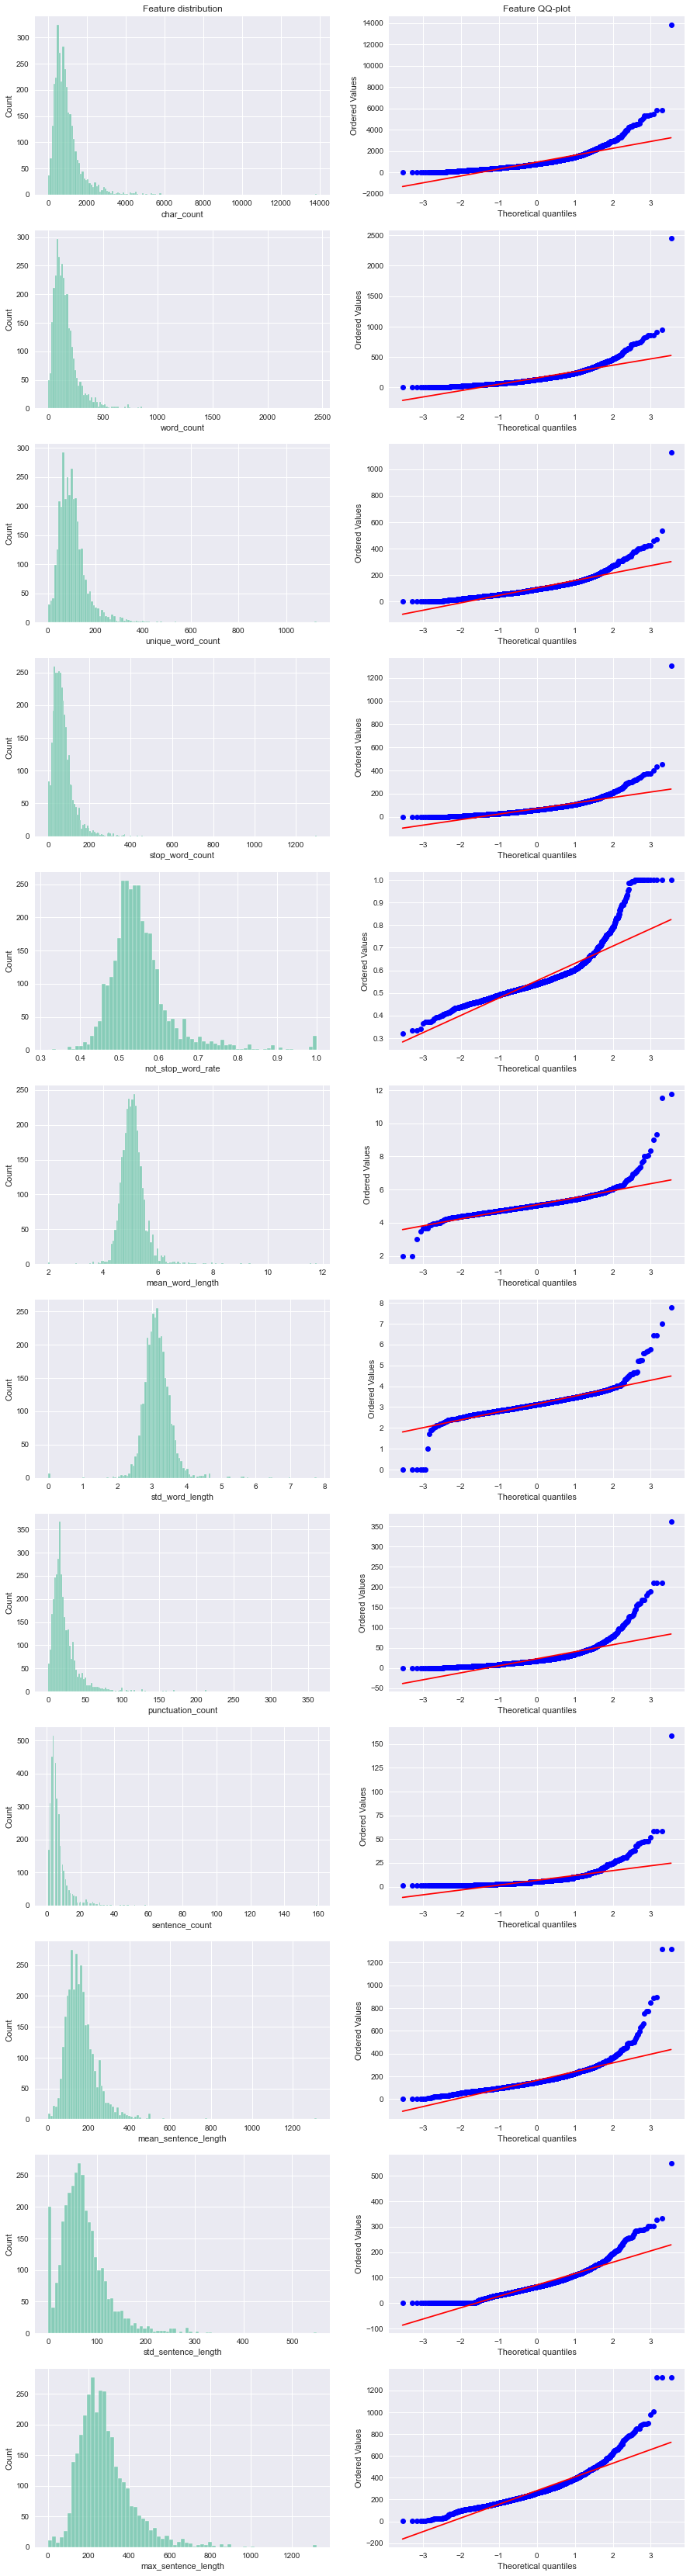

In [13]:
meta_features = [
    "char_count", "word_count", "unique_word_count", "stop_word_count",
    "not_stop_word_rate", "mean_word_length", "std_word_length", "punctuation_count",
    "sentence_count", "mean_sentence_length", "std_sentence_length", "max_sentence_length"
]
mfl = len(meta_features)
fig, axes = plt.subplots(nrows=mfl, ncols=2, figsize=(15, mfl*5))
for i in range(mfl):
    sns.histplot(df[meta_features[i]], ax=axes[i][0], color=palette[0])
    stats.probplot(df[meta_features[i]], plot=axes[i][1])
    axes[i][1].set_title("")
axes[0][0].set_title("Feature distribution", fontsize=12)
axes[0][1].set_title("Feature QQ-plot", fontsize=12)
plt.show()

There are some outliers that we can remove.

In [14]:
print(df[df["char_count"] >= 6000].index)
print(df[df["word_count"] >= 1000].index)
print(df[df["unique_word_count"] >= 600].index)
print(df[df["stop_word_count"] >= 500].index)
print(df[df["sentence_count"] >= 60].index)

Int64Index([1283], dtype='int64')
Int64Index([1283], dtype='int64')
Int64Index([1283], dtype='int64')
Int64Index([1283], dtype='int64')
Int64Index([1283], dtype='int64')


The row 1283 is a common outlier, and as it belong to the Training set, we can remove it.

In [15]:
df.drop(axis=0, index=1283, inplace=True)

Each column distribution has the following skewness.

In [16]:
print(f"The char_count column has a skewness of {skew(df.char_count):.3f}")
print(f"The word_count column has a skewness of {skew(df.word_count):.3f}")
print(f"The unique_word_count column has a skewness of {skew(df.unique_word_count):.3f}")
print(f"The stop_word_count column has a skewness of {skew(df.stop_word_count):.3f}")
print(f"The not_stop_word_rate column has a skewness of {skew(df.not_stop_word_rate):.3f}")
print(f"The mean_word_length column has a skewness of {skew(df.mean_word_length):.3f}")
print(f"The std_word_length column has a skewness of {skew(df.std_word_length):.3f}")
print(f"The punctuation_count column has a skewness of {skew(df.punctuation_count):.3f}")
print(f"The sentence_count column has a skewness of {skew(df.sentence_count):.3f}")
print(f"The mean_sentence_length column has a skewness of {skew(df.mean_sentence_length):.3f}")
print(f"The std_sentence_length column has a skewness of {skew(df.std_sentence_length):.3f}")
print(f"The max_sentence_length column has a skewness of {skew(df.max_sentence_length):.3f}")

The char_count column has a skewness of 2.264
The word_count column has a skewness of 2.159
The unique_word_count column has a skewness of 1.787
The stop_word_count column has a skewness of 2.098
The not_stop_word_rate column has a skewness of 2.112
The mean_word_length column has a skewness of 2.807
The std_word_length column has a skewness of 0.863
The punctuation_count column has a skewness of 3.487
The sentence_count column has a skewness of 3.240
The mean_sentence_length column has a skewness of 3.286
The std_sentence_length column has a skewness of 1.634
The max_sentence_length column has a skewness of 1.638


**To reduce the skewness, one can transform each column numerically**. In our case we are Root and Log-Transforming. (This step is completely optional)

In [17]:
df["char_count"] = df["char_count"] ** (1/4)
df["word_count"] = df["word_count"] ** (1/3)
df["unique_word_count"] = df["unique_word_count"] ** (2/5)
df["stop_word_count"] = df["stop_word_count"] ** (1/3)
idxs = df[df["not_stop_word_rate"] == 1].index
for idx in idxs:
    df.at[idx, "not_stop_word_rate"] = df.at[idx-1, "not_stop_word_rate"]
df["not_stop_word_rate"] = df["not_stop_word_rate"] ** (1/2)
idxs = df[df["mean_word_length"] <= 3].index
for idx in idxs:
    df.at[idx, "mean_word_length"] = df.at[idx-1, "mean_word_length"]
df["mean_word_length"] = df["mean_word_length"] ** (1/3)
df["std_word_length"] = df["std_word_length"] ** (9/10)
df["punctuation_count"] = np.log1p(df["punctuation_count"])
df["sentence_count"] = np.log1p(df["sentence_count"])
df["mean_sentence_length"] = df["mean_sentence_length"] ** (1/2)
df["std_sentence_length"] = df["std_sentence_length"] ** (1/3)
df["max_sentence_length"] = df["max_sentence_length"] ** (2/5)

The resulting skewness for each column is

In [18]:
print(f"The char_count column has a skewness of {skew(df.char_count):.3f}")
print(f"The word_count column has a skewness of {skew(df.word_count):.3f}")
print(f"The unique_word_count column has a skewness of {skew(df.unique_word_count):.3f}")
print(f"The stop_word_count column has a skewness of {skew(df.stop_word_count):.3f}")
print(f"The not_stop_word_rate column has a skewness of {skew(df.not_stop_word_rate):.3f}")
print(f"The mean_word_length column has a skewness of {skew(df.mean_word_length):.3f}")
print(f"The std_word_length column has a skewness of {skew(df.std_word_length):.3f}")
print(f"The punctuation_count column has a skewness of {skew(df.punctuation_count):.3f}")
print(f"The sentence_count column has a skewness of {skew(df.sentence_count):.3f}")
print(f"The mean_sentence_length column has a skewness of {skew(df.mean_sentence_length):.3f}")
print(f"The std_sentence_length column has a skewness of {skew(df.std_sentence_length):.3f}")
print(f"The max_sentence_length column has a skewness of {skew(df.max_sentence_length):.3f}")

The char_count column has a skewness of 0.032
The word_count column has a skewness of 0.249
The unique_word_count column has a skewness of 0.188
The stop_word_count column has a skewness of -0.207
The not_stop_word_rate column has a skewness of 1.358
The mean_word_length column has a skewness of 1.808
The std_word_length column has a skewness of 0.357
The punctuation_count column has a skewness of -0.315
The sentence_count column has a skewness of 0.482
The mean_sentence_length column has a skewness of 0.945
The std_sentence_length column has a skewness of -1.453
The max_sentence_length column has a skewness of 0.166


The distributions now look more Gaussian.

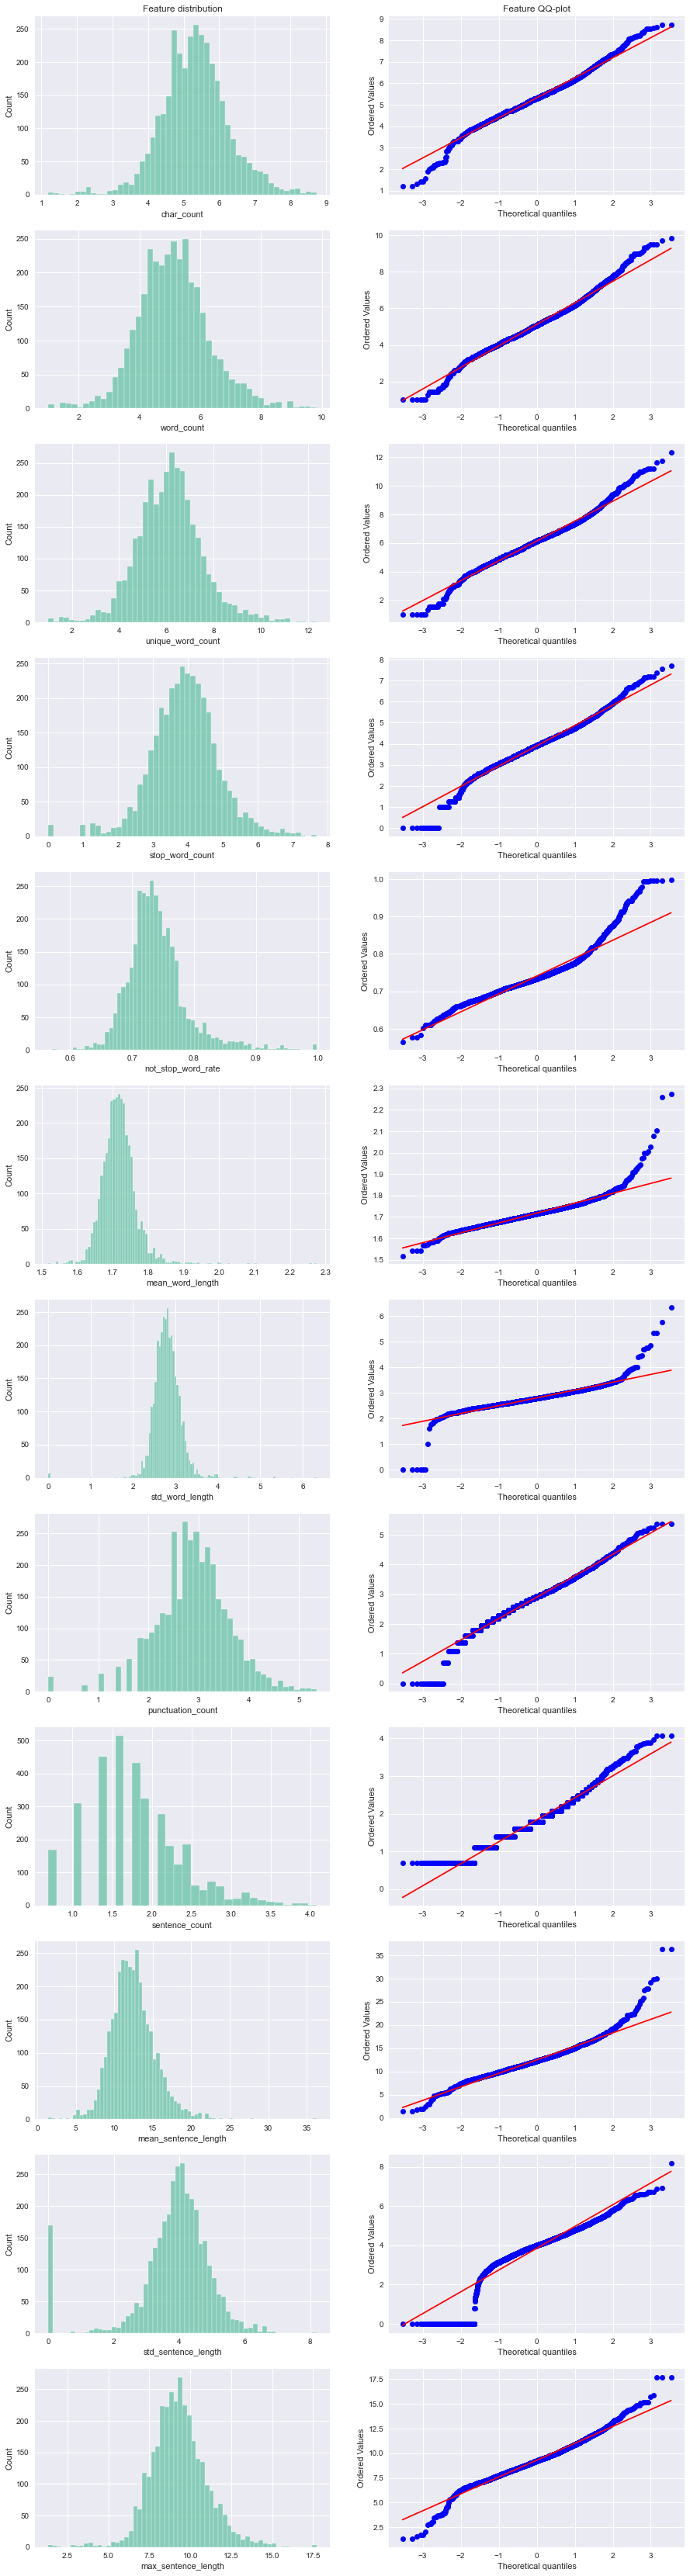

In [19]:
fig, axes = plt.subplots(nrows=mfl, ncols=2, figsize=(15, mfl*5))
for i in range(mfl):
    sns.histplot(df[meta_features[i]], ax=axes[i][0], color=palette[0])
    stats.probplot(df[meta_features[i]], plot=axes[i][1])
    axes[i][1].set_title("")
axes[0][0].set_title("Feature distribution", fontsize=12)
axes[0][1].set_title("Feature QQ-plot", fontsize=12)
plt.show()

### Linear Correlation

**Some of the above new features, can be redundant**. So we check the linear correlation of all of them in order to remove the correlated columns. (a simple rule of thumb is to **remove the columns with a correlation higher than ~0.9**)

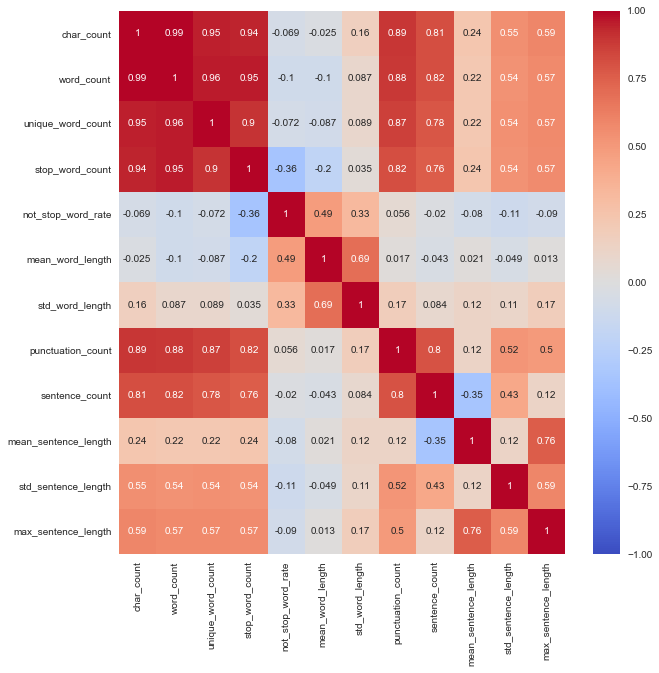

In [20]:
corr = df[meta_features].corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0, ax=ax)
plt.show()

In [21]:
df.drop(
    columns=["word_count", "unique_word_count", "stop_word_count", "punctuation_count"],
    inplace=True
)

The final data frame's shape is

In [22]:
print(df.shape)

(3363, 29)


### Relation with the topic column (only Training set)

We plot the relation of each new column with the target topic column. (only consider the Training set, as we dont know the topic for the Test set)

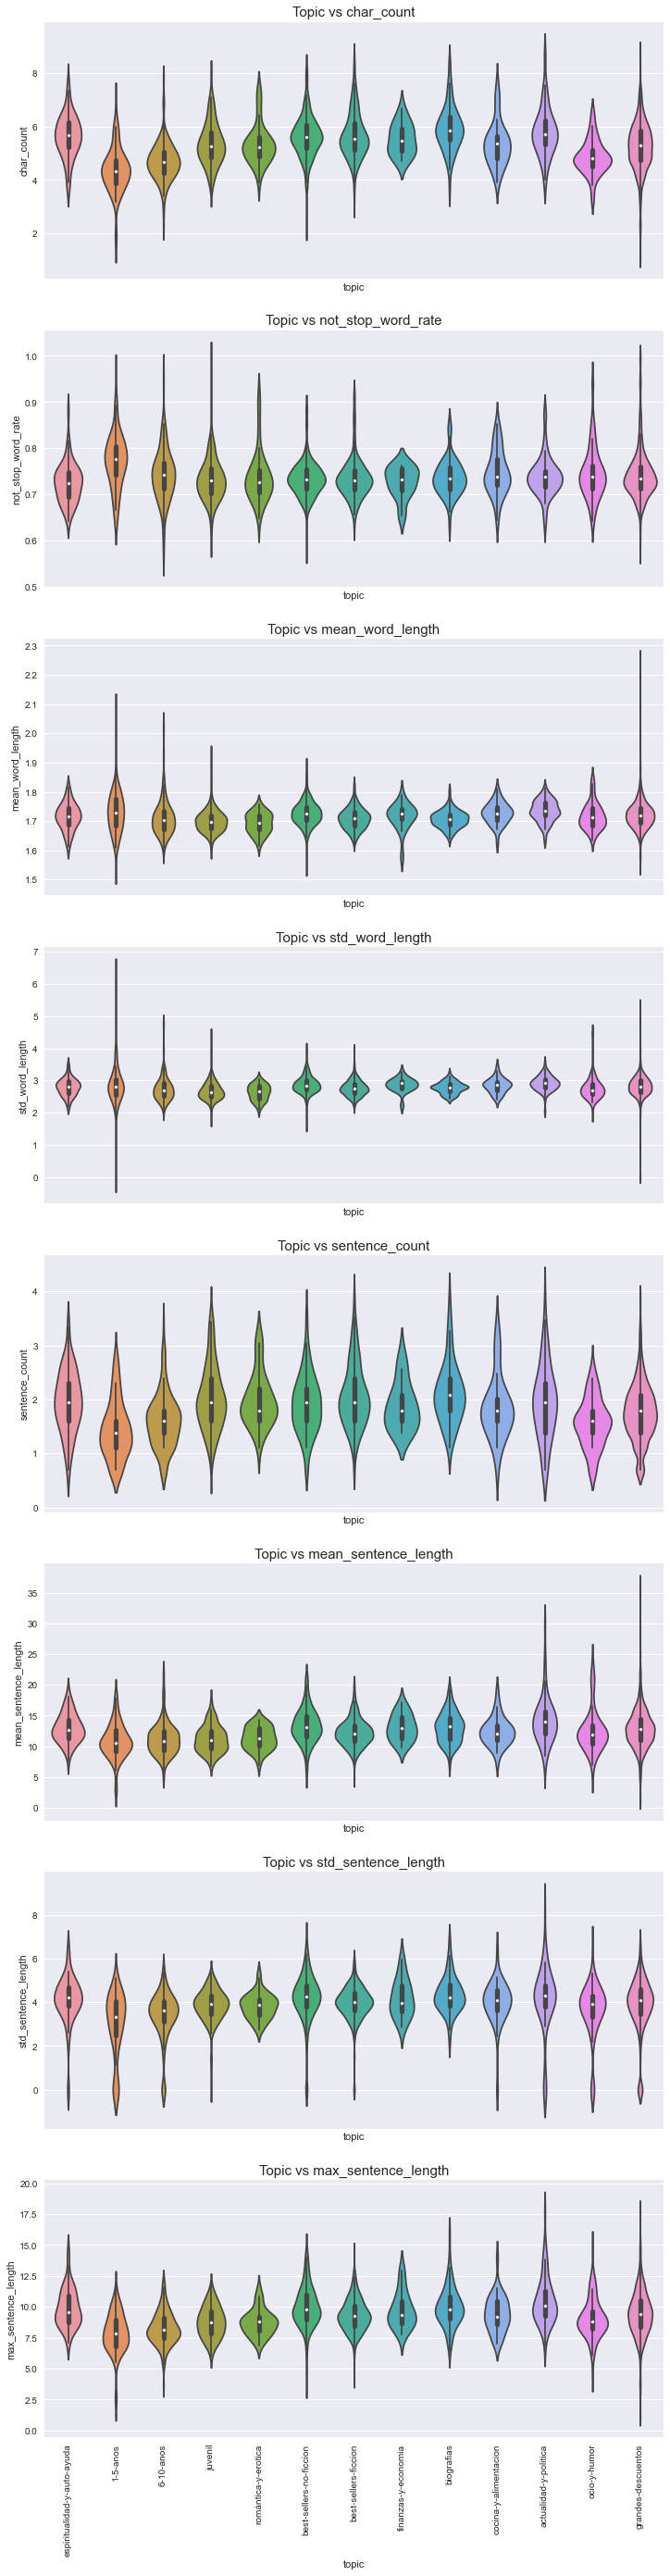

In [23]:
meta_features = [
    "char_count", "not_stop_word_rate", "mean_word_length", "std_word_length", "sentence_count",
    "mean_sentence_length", "std_sentence_length", "max_sentence_length"
]
mfl = len(meta_features)
fig, axes = plt.subplots(nrows=mfl, figsize=(12, mfl*6))
for i in range(mfl):
    sns.violinplot(x="topic", y=meta_features[i], data=df.iloc[0:df.shape[0]-700], ax=axes[i])
    axes[i].set_title("")
    axes[i].set_title("Topic vs " + meta_features[i], fontsize=15)
    if i != mfl-1:
        axes[i].set_xticks([])
axes[mfl-1].tick_params(axis="x", rotation=90)
plt.show()

## Word Embedding

We are going to use a pre-trained vector embedding (with 300 dimensions); each word will be represented as a numeric vector in a pre defined way.
To do that, first we need to clean each text, to get a better coverage of the embedder:



1.  Import the embedder.
2.  Check the vocabulary and text coverage of Training and Test sets.
3.  Replace the non covered words, with suitable ones.
4.  Repeat until getting an acceptable % of coverage.



Import the embedder.

In [24]:
# embedding_path = ".../SBW-vectors-300-min5.txt"
# def load_embedding(embedding_path):
#     print("Loading")
#     with open(embedding_path, encoding="utf8") as f:
#         content = f.readlines()
#     model = {}
#     for line in content:
#         split_line = line.split()
#         word = split_line[0]
#         embedding = np.array([float(val) for val in split_line[1: ]])
#         model[word] = embedding
#     print("Done", len(model), "words loaded!")
#     return model
# embedding_model = load_embedding(embedding_path)

Define the vocabulary and text check functions

In [25]:
# def build_vocab(X):
#     texts = X.apply(lambda x: x.split()).values
#     vocab = {}
#     for text in texts:
#         for word in text:
#             try:
#                 vocab[word] += 1
#             except KeyError:
#                 vocab[word] = 1
#     return vocab

# def check_embeddings_coverage(X, embeddings):
#     vocab = build_vocab(X)
#     covered = {}
#     oov = {}
#     n_covered = 0
#     n_oov = 0
#     for word in vocab:
#         try:
#             covered[word] = embeddings[word]
#             n_covered += vocab[word]
#         except:
#             oov[word] = vocab[word]
#             n_oov += vocab[word]
#     vocab_coverage = len(covered) / len(vocab)
#     text_coverage = (n_covered / (n_covered + n_oov))
#     return oov, vocab_coverage, text_coverage

Check the coverage

In [26]:
# train_oov, train_vocab_coverage, train_text_coverage = check_embeddings_coverage(
    # df.iloc[0:df.shape[0]-700]["review"], embedding_model
# )
# test_oov, test_vocab_coverage, test_text_coverage = check_embeddings_coverage(
    # df.iloc[df.shape[0]-700:df.shape[0]]["review"], embedding_model
# )
# print(
    # f"In Training Set: \n",
    # f"Embedding covers {train_vocab_coverage:.2%} of vocabulary\n",
    # f"and {train_text_coverage:.2%} of text."
# )
# print(
    # f"In Test Set: \n",
    # f"Embedding covers {test_vocab_coverage:.2%} of vocabulary\n",
    # f"and {test_text_coverage:.2%} of text."

Print the list of non covered words 

In [27]:
# print(sorted(train_oov.items(), key=lambda item:item[1])[::-1])
# print(sorted(test_oov.items(), key=lambda item:item[1])[::-1])

Create the text cleaner function. 


In [28]:
def text_cleaner(text):
    text = text.replace("\xa0", " ")
    text = text.replace("\ xa0", " ")
    text = text.replace("\x93", " ")
    text = text.replace("\x94", " ")
    text = text.replace("\x95", " ")
    text = text.replace("\x96", " ")
    text = text.replace("\x97", " ")
    punctuations = '"' + "!#$%&/()<=>?¡¿,.-;:_{}[]´+¨*^`~«»º¬°|'@•“”–…·‘’―¤€£✓π∆¶" + "—"
    for p in punctuations:
        text = text.replace(p, " ")
    text = re.sub(r"[0-9]", " ", text)
    text = text.replace("Caligrafix", "caligrafia")
    text = text.replace("Abremente", "Abre Mente")
    text = text.replace("Chimamanda", "Chima")
    text = text.replace("Ratford", "Rat Ford")
    text = text.replace("elaboracin", "elaboración")
    text = text.replace("posverdad", "post verdad")
    text = text.replace("ZAYN", "Zayn")
    text = text.replace("Chacota", "chacota")
    text = text.replace("APLAUDIDA", "aplaudida")
    text = text.replace("empezarLeParisien", "empezar Le Parisien")
    text = text.replace("másEncuadernación", "más Encuadernación")
    text = text.replace("millennial", "milenial")
    text = text.replace("CartonéColección", "Cartoné Colección")
    text = text.replace("Patrioteros", "patrioteros")
    text = text.replace("problemticas", "problemáticas")
    text = text.replace("cancin", "canción")
    text = text.replace("ocano", "océano")
    text = text.replace("interZona", "inter zona")
    text = text.replace("Cartoné", "cartoné")
    return text

Define and fill the new column, with the text cleaned.

In [29]:
df["review_cleaned"] = df["review"].apply(lambda x: text_cleaner(x))

We got a final coverage of 93.66% of vocabulary and 99.18% of text for the Training set,
and 96.31% of vocabulary and 99.19% of text for the Test set.

## CSV write

Write the processed data in two new datasets.

In [30]:
train_2 = df.iloc[0:df.shape[0]-700]
test_2 = df.iloc[df.shape[0]-700:df.shape[0]].drop(columns=["topic"])
train_2.reset_index(drop=True, inplace=True)
train_2.to_csv("train_2.csv", index=False)
test_2.to_csv("test_2.csv", index=False)